# Multimaterial Interfaces Notebook

Displacement map shape: (2, 300)


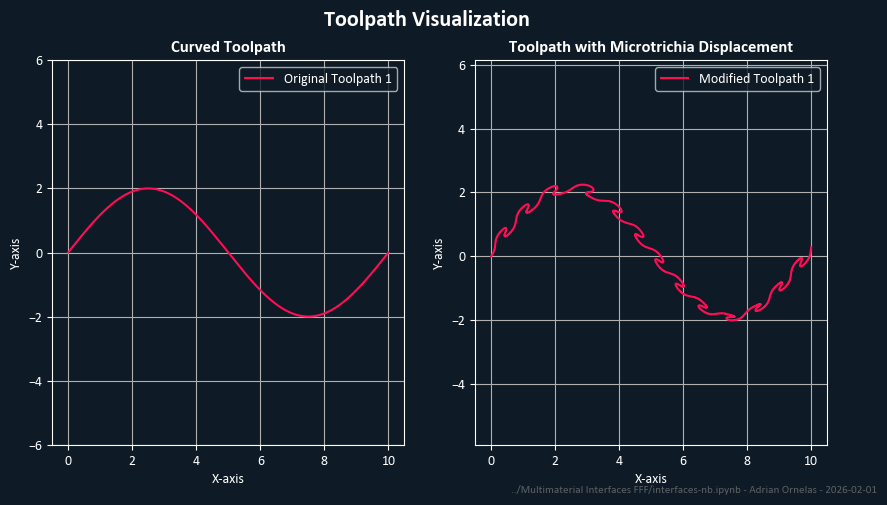

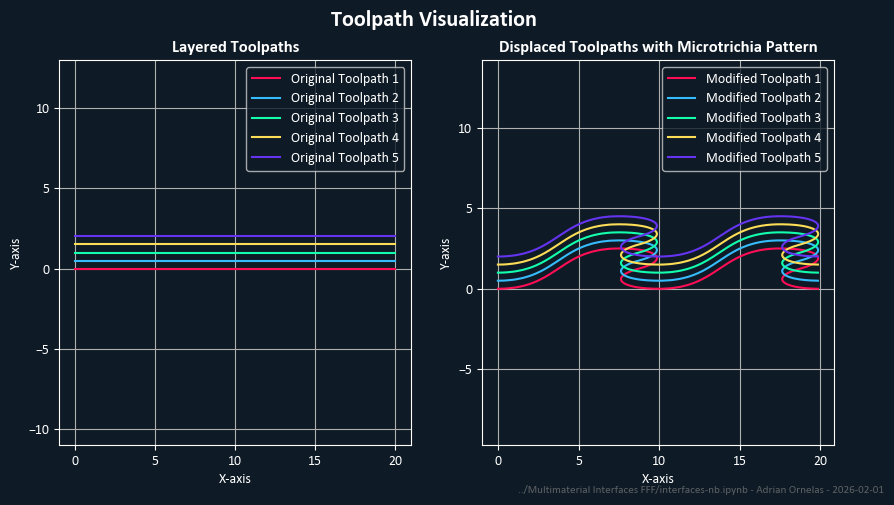

In [74]:
# Plotting utility for visualization

# Toolpaths are stored as two column arrays (X, Y)

import matplotlib.pyplot as plt
import numpy as np
import themes # Custom theme library, local module
import datetime
import bezier
import ipynbname

themes.apply_plot_theme("Friday")

nb_path = str(ipynbname.path()).split("\\")[-2:]
nb_path = f"../{nb_path[0]}/{nb_path[1]}"

def fig_watermark(fig, file=nb_path, author = "Adrian Ornelas", date_string=datetime.datetime.now().strftime("%Y-%m-%d")):
    """Appends the date string to the bottom right corner of the plot figure."""
    fig.text(0.95, 0.01, f"{file} - {author} - {date_string}",
             verticalalignment='bottom', horizontalalignment='right',
             fontsize=8, color='gray', alpha=0.7)

def plot_toolpaths(original_toolpath, modified_toolpath, fig_title_1="Original Toolpaths", fig_title_2="Modified Toolpaths", line_style='-'):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)

    if type(original_toolpath) is not list:
        original_toolpath = [original_toolpath]

    for idx, path in enumerate(original_toolpath):
        plt.plot(path[:, 0], path[:, 1], line_style, label=f'Original Toolpath {idx+1}')

    plt.title(fig_title_1)
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.axis('equal')
    plt.legend()
    plt.grid()

    plt.subplot(1, 2, 2)
    if type(modified_toolpath) is not list:
        modified_toolpath = [modified_toolpath]

    for idx, path in enumerate(modified_toolpath):
        plt.plot(path[:, 0], path[:, 1], line_style, label=f'Modified Toolpath {idx+1}')

    plt.title(fig_title_2)
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.axis('equal')
    plt.legend()
    plt.grid()

    plt.suptitle('Toolpath Visualization', fontsize=16)

    fig_watermark(plt.gcf())
    plt.show()

def plot_direction_normal_vectors(positions, directions, normal, exclude='', line_style='-'):
    """Plot the positions as points, and the direction and normal vectors as arrows.
    Optionally exclude certain inputs to simplify the plot.
    To exclude positions, pass a string with the letter 'p' , 'd' for directions, 'n' for normals."""

    plt.figure()

        
    if 'd' not in exclude:
        plt.quiver(positions[:, 0], positions[:, 1], directions[:, 0], directions[:, 1], angles='xy', scale_units='xy', scale=1, color='b', label='Direction Vectors',width=0.005)
    if 'n' not in exclude:
        plt.quiver(positions[:, 0], positions[:, 1], normal[:, 0], normal[:, 1], angles='xy', scale_units='xy', scale=1, color='r', label='Normal Vectors',width=0.005)
    if 'p' not in exclude:
        plt.plot(positions[:, 0], positions[:, 1], 'o', label='Original Toolpath', color='#ffca08')

    plt.title('Toolpath with Direction and Normal Vectors')
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.axis('equal')
    plt.legend()
    plt.grid()
    fig_watermark(plt.gcf())
    plt.show()


def gen_parallel(start_coord, end_coord, num_points, num_paths=1, offset_distance=1):
    """Generates parallel toolpaths between start and end points.
    Extra lines are generated by offsetting the original line in the direction of the normal vector.
    These are in the form of two column arrays (X, Y) representing the toolpath coordinates arranged in a list"""

    start = np.array(start_coord)
    end = np.array(end_coord)
    direction = end - start
    length = np.linalg.norm(direction)
    direction = direction / length  # Normalize

    # Calculate normal vector
    normal = np.array([-direction[1], direction[0]])

    toolpaths = []
    for i in range(num_paths):
        offset = normal * offset_distance * i
        new_start = start + offset
        new_end = end + offset
        x_values = np.linspace(new_start[0], new_end[0], num_points)
        y_values = np.linspace(new_start[1], new_end[1], num_points)
        toolpath = np.column_stack((x_values, y_values))
        toolpaths.append(toolpath)

    if num_paths == 1:
        return toolpaths[0]

    return toolpaths

def gen_sine(start_x, end_x, num_points, amplitude, frequency):
    x_values = np.linspace(start_x, end_x, num_points)
    y_values = amplitude * np.sin(frequency * x_values)
    toolpath = np.column_stack((x_values, y_values))
    return toolpath


def gen_microtrichia(height, ramp, ramp_shift, base_ratio, tip_angle, tip_size,resolution=100):
    """Returns an np.array representing the toolpath in 2D for a microtrichia shape based on input parameters.
    
    height: Height of the microtrichia peak
    ramp: Curvature adjustment for the ramp section
    ramp_shift: Horizontal shift for the ramp section
    base_ratio: Ratio of the base width to the total width (0 to 1)
    tip_angle: Angle of the tip in degrees
    tip_size: Size of the tip curvature
    resolution: Number of points to evaluate on each bezier curve segment"""

    # Define key points that bezier curves will pass through
    origin = (0,0)
    peak = (base_ratio, height)
    midpoint = ((1-base_ratio)/2 + base_ratio, height/2)
    end_point = (1,0)

    # Define control nodes for Bezier curves
    ramp_midpoint = base_ratio/2-ramp_shift

    tip_angle_rad = np.radians(tip_angle)
    top_tip_control = (tip_size * np.cos(tip_angle_rad) + midpoint[0], tip_size * np.sin(tip_angle_rad) + midpoint[1])
    bottom_tip_control = (-tip_size * np.cos(tip_angle_rad) + midpoint[0], -tip_size * np.sin(tip_angle_rad) + midpoint[1])

    microtrichia_nodes_1 = np.array([[origin[0], ramp_midpoint+ramp, ramp_midpoint-ramp, peak[0]],
                                        [origin[1], origin[1], peak[1], peak[1]]]) # XY pairs, 1: origin, 2 & 3 ramp curvature, 4: topmost point
    
    microtrichia_nodes_2 = np.array([[peak[0], 1, top_tip_control[0], midpoint[0]],
                                        [peak[1], peak[1], top_tip_control[1], midpoint[1]]]) # XY pairs, 1: topmost point, 2 & 3 curvature for tip, 3 and 2 (next) must be equal in magnitude and coincident, 4: midpoint
    
    microtrichia_nodes_3 = np.array([[midpoint[0], bottom_tip_control[0], base_ratio, end_point[0]],
                                        [midpoint[1], bottom_tip_control[1], 0., end_point[1]]]) # XY pairs, 1: midpoint, 2 & 3 ramp curvature, 4: end point
    
    microtrichia_curve_1 = bezier.Curve(microtrichia_nodes_1, degree=3)
    microtrichia_curve_2 = bezier.Curve(microtrichia_nodes_2, degree=3)
    microtrichia_curve_3 = bezier.Curve(microtrichia_nodes_3, degree=3)
    curve_1_points = microtrichia_curve_1.evaluate_multi(np.linspace(0,1,resolution))
    curve_2_points = microtrichia_curve_2.evaluate_multi(np.linspace(0,1,resolution))
    curve_3_points = microtrichia_curve_3.evaluate_multi(np.linspace(0,1,resolution))

    return np.hstack([curve_1_points, curve_2_points, curve_3_points])

def get_pos_dir_norm(toolpath):
    positions = toolpath[:-1]  # All but last point
    directions = np.diff(toolpath, axis=0)  # Differences between consecutive points
    normals = np.zeros_like(directions)
    normals[:, 0] = -directions[:, 1]
    normals[:, 1] = directions[:, 0]
    return positions, directions, normals

# A displacement map is a function bound from 0 to 1 in t that outputs an x,y displacement based on the distance traveled in t

def displacement_func(t, displacement_map=np.array([[0],[0]])):
    """Displacement function that maps t (0 to 1) to a displacement vector."""
    index = int(t * (displacement_map.shape[1] - 1))
    return displacement_map[:, index]

def apply_displacement(toolpath, period=2, displacement_map = np.array([[0],[0]])):
    """Generates a sawtooth wave displacement map along the toolpath."""
    positions, directions, normals = get_pos_dir_norm(toolpath)
    displaced_positions = np.copy(positions)
    num_points = positions.shape[0]
    
    dist_travled = 0.0
    for i in range(num_points):
        # Calculate the distance along the toolpath
        dist_travled += np.linalg.norm(directions[i-1]) if i > 0 else 0.0
        
        # Determine the local position at this distance (t=0 to 1), normalized by period
        t = (dist_travled % period) / period
        dir_norm = directions[i] / np.linalg.norm(directions[i])
        norm_norm = normals[i] / np.linalg.norm(normals[i])
        # Apply displacements from the displacement map according to t and period
        delta_x = ((displacement_func(t, displacement_map)[0]*period) - period*t) * dir_norm
        delta_y = ((displacement_func(t, displacement_map)[1]*period) ) * norm_norm
        # print(f"Point {i}: t={t:.2f}, delta_x={delta_x}, delta_y={delta_y}")
        displaced_positions[i] += delta_x + delta_y
        # print(f"Original Pos: {positions[i]}, Displaced Pos: {displaced_positions[i]}")
    
    return displaced_positions

# plot_toolpaths(gen_parallel((0, 0), (10, 0), 20, num_paths=1), 
#                gen_parallel((0, 0), (10, 0), 20, num_paths=3, offset_distance=1),
#                fig_title_1="Example Original Toolpaths", fig_title_2="Example Modified Toolpaths")

height = 0.25
ramp = 0
ramp_shift = 0
base_ratio = 0.75
tip_angle = 15
tip_size = 0.2

disp_microtrichia = gen_microtrichia(height=height, ramp=ramp, ramp_shift=ramp_shift, base_ratio=base_ratio, tip_angle=tip_angle, tip_size=tip_size, resolution=100)

layered_toolpath = gen_parallel((0, 0), (20, 0), 500, num_paths=5, offset_distance=0.5)

displaced_toolpaths = []
for path in layered_toolpath:
    displaced_path = apply_displacement(path, period=10, displacement_map=disp_microtrichia)
    displaced_toolpaths.append(displaced_path)


# original_toolpath = gen_parallel((0, 0), (3, 0), 1000, num_paths=1)
original_toolpath = gen_sine(0, 10, 10000, amplitude=2, frequency=1 * np.pi / 5)
disp_microtrichia = gen_microtrichia(height=height, ramp=ramp, ramp_shift=ramp_shift, base_ratio=base_ratio, tip_angle=tip_angle, tip_size=tip_size, resolution=100)

print(f"Displacement map shape: {disp_microtrichia.shape}")
modified_toolpath = apply_displacement(original_toolpath, period=1, displacement_map=disp_microtrichia)

plot_toolpaths(original_toolpath, modified_toolpath,
               fig_title_1="Curved Toolpath", fig_title_2="Toolpath with Microtrichia Displacement")

plot_toolpaths(layered_toolpath, displaced_toolpaths,
               fig_title_1="Layered Toolpaths", fig_title_2="Displaced Toolpaths with Microtrichia Pattern") 

Need a local coordinate system.

XYZ are taken as global coordinates. Let's find parametrically define a coordinate system local to each point containing a direction and normal vector relative to a start to finish condition and the coordinates: TUZ (T = direction, U = Normal, Z = Z)

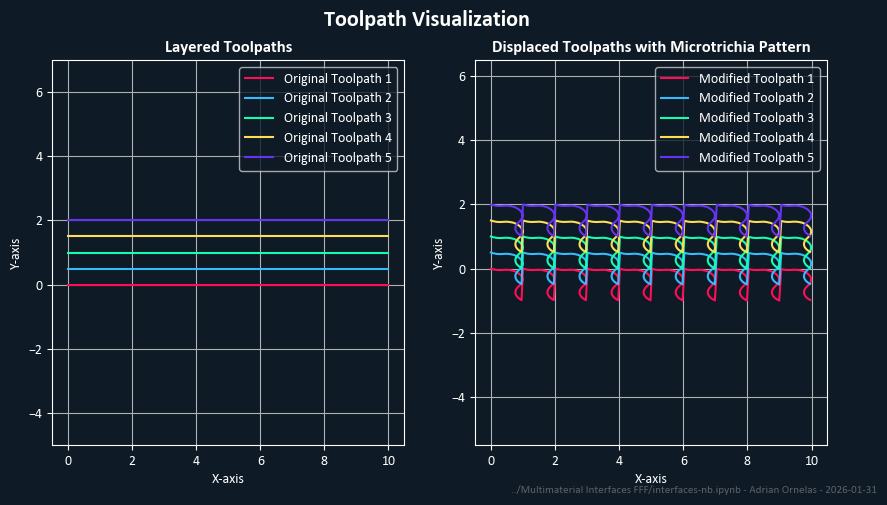

In [18]:
height = 0.25
ramp = 0
ramp_shift = 0
base_ratio = 0.75
tip_angle = 15
tip_size = 0.2

disp_microtrichia = gen_microtrichia(height=height, ramp=ramp, ramp_shift=ramp_shift, base_ratio=base_ratio, tip_angle=tip_angle, tip_size=tip_size, resolution=100)

layered_toolpath = gen_parallel((0, 0), (10, 0), 500, num_paths=5, offset_distance=0.5)

displaced_toolpaths = []
for path in layered_toolpath:
    displaced_path = apply_displacement(path, period=1, displacement_map=disp_microtrichia)
    displaced_toolpaths.append(displaced_path)
plot_toolpaths(layered_toolpath, displaced_toolpaths,
               fig_title_1="Layered Toolpaths", fig_title_2="Displaced Toolpaths with Microtrichia Pattern") 


Displacement map shape: (2, 300)
Point 0: t=0.00, delta_x=[0. 0.], delta_y=[-0.  0.]
Original Pos: [0. 0.], Displaced Pos: [0. 0.]
Point 1: t=0.00, delta_x=[-0.0010001  -0.00062838], delta_y=[ 0.00053207 -0.00053207]
Original Pos: [0.0010001  0.00062838], Displaced Pos: [ 0.00053207 -0.00053207]
Point 2: t=0.00, delta_x=[-0.0020002  -0.00125676], delta_y=[ 0.00106414 -0.00106414]
Original Pos: [0.0020002  0.00125676], Displaced Pos: [ 0.00106414 -0.00106414]
Point 3: t=0.00, delta_x=[0.00652513 0.00409986], delta_y=[ 0.00155578 -0.00153186]
Original Pos: [0.0030003  0.00188514], Displaced Pos: [0.01108121 0.00445315]
Point 4: t=0.00, delta_x=[0.00552503 0.00347148], delta_y=[ 0.00208785 -0.00206393]
Original Pos: [0.0040004  0.00251352], Displaced Pos: [0.01161328 0.00392107]
Point 5: t=0.01, delta_x=[0.00452493 0.00284309], delta_y=[ 0.00261992 -0.002596  ]
Original Pos: [0.0050005  0.00314191], Displaced Pos: [0.01214535 0.003389  ]
Point 6: t=0.01, delta_x=[0.01285981 0.00808004], d

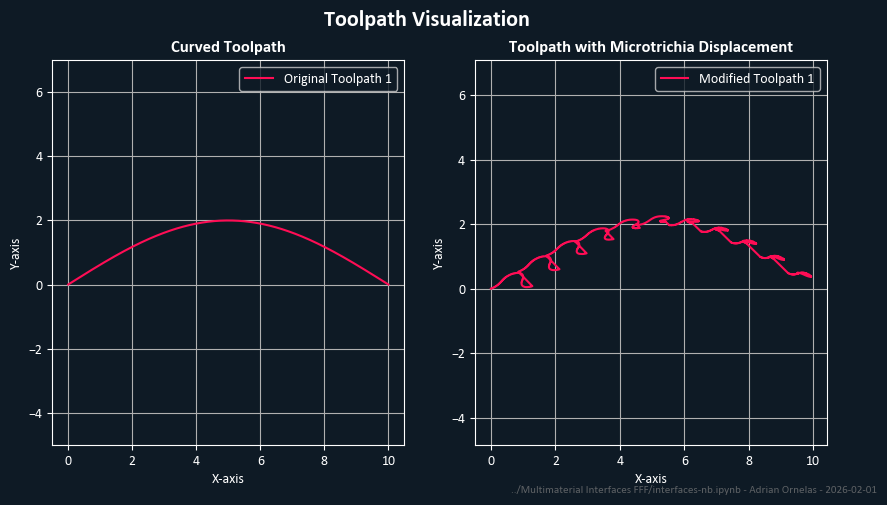

In [50]:
# Apply microtrichia generation as a displacement map to a straight line toolpath

height = 0.25
ramp = 0
ramp_shift = 0
base_ratio = 0.75
tip_angle = 15
tip_size = 0.2

# original_toolpath = gen_parallel((0, 0), (3, 0), 1000, num_paths=1)
original_toolpath = gen_sine(0, 10, 10000, amplitude=2, frequency=1 * np.pi / 10)
disp_microtrichia = gen_microtrichia(height=height, ramp=ramp, ramp_shift=ramp_shift, base_ratio=base_ratio, tip_angle=tip_angle, tip_size=tip_size, resolution=100)

print(f"Displacement map shape: {disp_microtrichia.shape}")
modified_toolpath = apply_displacement(original_toolpath, period=1, displacement_map=disp_microtrichia)

plot_toolpaths(original_toolpath, modified_toolpath,
               fig_title_1="Curved Toolpath", fig_title_2="Toolpath with Microtrichia Displacement")

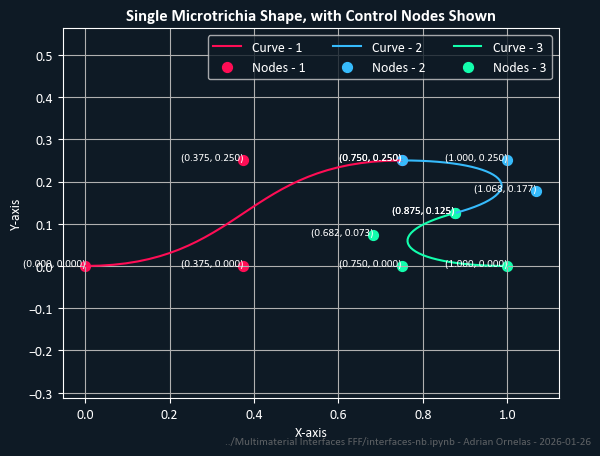

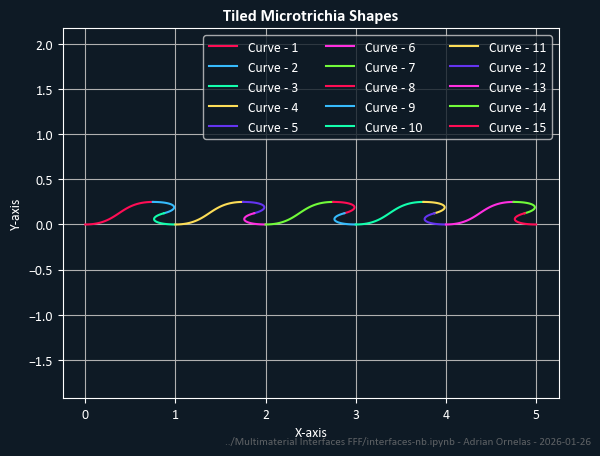

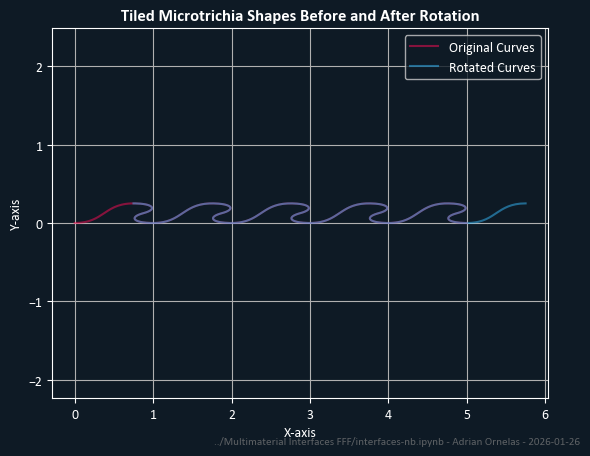

In [3]:
import bezier

def plot_bezier_curves(curves, nodes, title='Bezier Curves', nodes_visible=True):
    plt.figure()
    labels = [''] * len(curves)
    for i in range(len(curves)):
        labels[i] = f'{i+1}'
        plt.plot(curves[i][0, :], curves[i][1, :], label=f'Curve - {labels[i]}')

        if nodes_visible:
            plt.scatter(nodes[i][0, :], nodes[i][1, :], s=50, label=f'Nodes - {labels[i]}')
            for x, y in zip(nodes[i][0, :], nodes[i][1, :]):
                plt.text(x, y, f'({x:.3f}, {y:.3f})', fontsize=8, ha='right')

    plt.title(title)
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.axis('equal')
    plt.grid()
    # plt.xlim(-0.1, 1.1)
    # plt.ylim(-0.1, 1.1)
    plt.legend(ncol=3)
    fig_watermark(plt.gcf())
    plt.show()

def gen_microtrichia_with_nodes(height, ramp, ramp_shift, base_ratio, tip_angle, tip_size,resolution=100):
    """Returns the bezier, with nodes"""

    # Define key points that bezier curves will pass through
    origin = (0,0)
    peak = (base_ratio, height)
    midpoint = ((1-base_ratio)/2 + base_ratio, height/2)
    end_point = (1,0)

    # Define control nodes for Bezier curves
    ramp_midpoint = base_ratio/2-ramp_shift

    tip_angle_rad = np.radians(tip_angle)
    top_tip_control = (tip_size * np.cos(tip_angle_rad) + midpoint[0], tip_size * np.sin(tip_angle_rad) + midpoint[1])
    bottom_tip_control = (-tip_size * np.cos(tip_angle_rad) + midpoint[0], -tip_size * np.sin(tip_angle_rad) + midpoint[1])

    microtrichia_nodes_1 = np.array([[origin[0], ramp_midpoint+ramp, ramp_midpoint-ramp, peak[0]],
                                        [origin[1], origin[1], peak[1], peak[1]]]) # XY pairs, 1: origin, 2 & 3 ramp curvature, 4: topmost point
    
    microtrichia_nodes_2 = np.array([[peak[0], 1, top_tip_control[0], midpoint[0]],
                                        [peak[1], peak[1], top_tip_control[1], midpoint[1]]]) # XY pairs, 1: topmost point, 2 & 3 curvature for tip, 3 and 2 (next) must be equal in magnitude and coincident, 4: midpoint
    
    microtrichia_nodes_3 = np.array([[midpoint[0], bottom_tip_control[0], base_ratio, end_point[0]],
                                        [midpoint[1], bottom_tip_control[1], 0., end_point[1]]]) # XY pairs, 1: midpoint, 2 & 3 ramp curvature, 4: end point
    
    microtrichia_curve_1 = bezier.Curve(microtrichia_nodes_1, degree=3)
    microtrichia_curve_2 = bezier.Curve(microtrichia_nodes_2, degree=3)
    microtrichia_curve_3 = bezier.Curve(microtrichia_nodes_3, degree=3)
    curve_1_points = microtrichia_curve_1.evaluate_multi(np.linspace(0,1,resolution))
    curve_2_points = microtrichia_curve_2.evaluate_multi(np.linspace(0,1,resolution))
    curve_3_points = microtrichia_curve_3.evaluate_multi(np.linspace(0,1,resolution))


    return [curve_1_points, curve_2_points, curve_3_points], [microtrichia_nodes_1, microtrichia_nodes_2, microtrichia_nodes_3]

    # return np.hstack([curve_1_points, curve_2_points, curve_3_points]), np.hstack([microtrichia_nodes_1, microtrichia_nodes_2, microtrichia_nodes_3])

height = 0.25
ramp = 0
ramp_shift = 0
base_ratio = 0.75
tip_angle = 15
tip_size = 0.2

curves, nodes = gen_microtrichia_with_nodes(height, ramp, ramp_shift, base_ratio, tip_angle, tip_size, resolution=33)

plot_bezier_curves(curves, nodes, title='Single Microtrichia Shape, with Control Nodes Shown', nodes_visible=True)

# Tile curves to create an array of microtrichia

def tile_microtrichia(curves, nodes, num_tiles, spacing):
    tiled_curves = []
    tiled_nodes = []
    for i in range(num_tiles):
        x_offset = i * spacing
        for curve in curves:
            shifted_curve = curve + np.array([[x_offset], [0]])
            tiled_curves.append(shifted_curve)
        for node in nodes:
            shifted_node = node + np.array([[x_offset], [0]])
            tiled_nodes.append(shifted_node)
    return tiled_curves, tiled_nodes

tiled_curves, tiled_nodes = tile_microtrichia(curves, nodes, num_tiles=5, spacing=1)

plot_bezier_curves(tiled_curves, tiled_nodes, title='Tiled Microtrichia Shapes', nodes_visible=False)

# Compress tiled curves and nodes into single arrays for plotting

all_curves = np.hstack(tiled_curves)
all_nodes = np.hstack(tiled_nodes)

# rotate all curves by 180 degrees

theta = np.radians(180)
rotation_matrix = np.array([[np.cos(theta), -np.sin(theta)],
                             [np.sin(theta), np.cos(theta)]])

all_curves_rotated = rotation_matrix @ all_curves
all_nodes_rotated = rotation_matrix @ all_nodes

# Translate rotated curves to the right for visibility
translation_vector = np.array([[5.75], [0.25]])

all_curves_rotated += translation_vector
all_nodes_rotated += translation_vector

plt.figure()
# plot_bezier_curves([all_curves, all_curves_rotated], [all_nodes, all_nodes_rotated], title='Tiled Microtrichia Shapes Before and After Rotation')

plt.plot(all_curves[0, :], all_curves[1, :], label='Original Curves', alpha=0.5)
plt.plot(all_curves_rotated[0, :], all_curves_rotated[1, :], label='Rotated Curves', alpha=0.5)
plt.title('Tiled Microtrichia Shapes Before and After Rotation')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend()

plt.axis('equal')
plt.grid()
fig_watermark(plt.gcf())
plt.show()


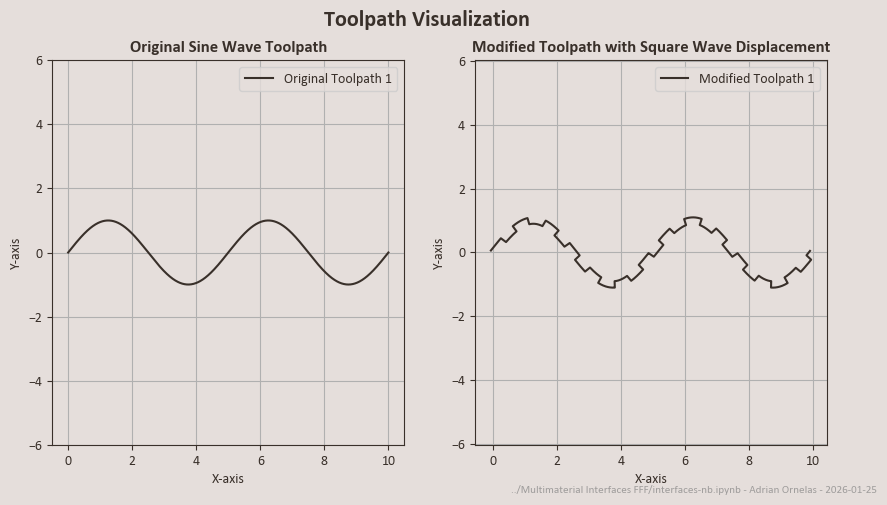

In [2]:
# Parametric 2D displacement map, using local coordinates, and importantly, local distances

original_toolpath = gen_sine(0, 10, 1000, amplitude=1, frequency=2 * np.pi / 5)
# original_toolpath = generate_parallel_toolpaths((0, 0), (10, 0), 1000, num_paths=1)[0]

positions, directions, normals = get_pos_dir_norm(original_toolpath)

def disp_square_wave(positions, directions, normals, amplitude=0.5, period=2):
    """Generates a square wave displacement map along the toolpath."""
    displaced_positions = np.copy(positions)
    num_points = positions.shape[0]

    dist_travled = 0.0
    for i in range(num_points):
        # Calculate the distance along the toolpath
        dist_travled += np.linalg.norm(directions[i-1]) if i > 0 else 0.0
        
        # Determine the square wave value at this distance
        wave_value = amplitude if (dist_travled // (period / 2)) % 2 == 0 else -amplitude
        
        # Apply displacement in the normal direction
        displaced_positions[i] += wave_value * (normals[i] / np.linalg.norm(normals[i]))
    
    return displaced_positions

def disp_sawtooth_wave(positions, directions, normals, amplitude=0.5, period=2):
    """Generates a sawtooth wave displacement map along the toolpath."""
    displaced_positions = np.copy(positions)
    num_points = positions.shape[0]

    dist_travled = 0.0
    for i in range(num_points):
        # Calculate the distance along the toolpath
        dist_travled += np.linalg.norm(directions[i-1]) if i > 0 else 0.0
        
        # Determine the sawtooth wave value at this distance
        cycle_pos = dist_travled % period
        wave_value = (cycle_pos / period) * amplitude
        
        # Apply displacement in the normal direction
        displaced_positions[i] += wave_value * (normals[i] / np.linalg.norm(normals[i]))
    
    return displaced_positions

# modified_toolpath = disp_sawtooth_wave(positions, directions, normals, period=1, amplitude=0.5)
modified_toolpath = disp_square_wave(positions, directions, normals, period=1, amplitude=0.1)

plot_toolpaths(original_toolpath, modified_toolpath,
               fig_title_1="Original Sine Wave Toolpath", fig_title_2="Modified Toolpath with Square Wave Displacement")

# plot_direction_normal_vectors(positions, directions, normals, 'p')

# positions_mod, directions_mod, normals_mod = get_pos_dir_norm(modified_toolpath)
# plot_direction_normal_vectors(positions_mod, directions_mod, normals_mod, 'p')

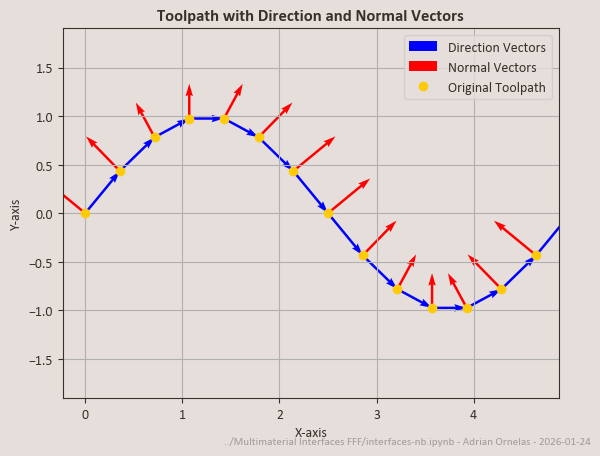

In [60]:
# Create a sinusoidal toolpath

toolpath = gen_sine(0, 5, 15, amplitude=1, frequency=2 * np.pi / 5)

# Given a toolpath, we need to get the position coordinates and direction vectors for each segment

positions, directions, normals = get_pos_dir_norm(toolpath)

plot_direction_normal_vectors(positions, directions, normals)

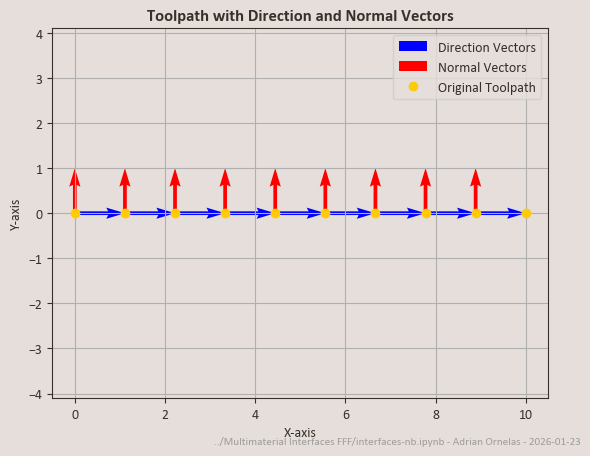

In [ ]:
original_toolpath = gen_parallel((0, 0), (10, 0), 10, num_paths=1)

# Given a toolpath, we need to get the position coordinates and direction vectors for each segment

positions = original_toolpath[:-1]  # All but last point
directions = np.diff(original_toolpath, axis=0)  # Differences between consecutive points
normal = np.zeros_like(directions)
normal[:, 0] = -directions[:, 1]
normal[:, 1] = directions[:, 0]
# Normalize normal vectors
norms = np.linalg.norm(normal, axis=1, keepdims=True)
normal = normal / norms

plt.quiver(positions[:, 0], positions[:, 1], directions[:, 0], directions[:, 1], angles='xy', scale_units='xy', scale=1, color='b', label='Direction Vectors')
plt.quiver(positions[:, 0], positions[:, 1], normal[:, 0], normal[:, 1], angles='xy', scale_units='xy', scale=1, color='r', label='Normal Vectors')
plt.plot(original_toolpath[:, 0], original_toolpath[:, 1], 'o', label='Original Toolpath', color='#ffca08')
plt.title('Toolpath with Direction and Normal Vectors')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.axis('equal')
plt.legend()
plt.grid()
fig_watermark(plt.gcf())
plt.show()

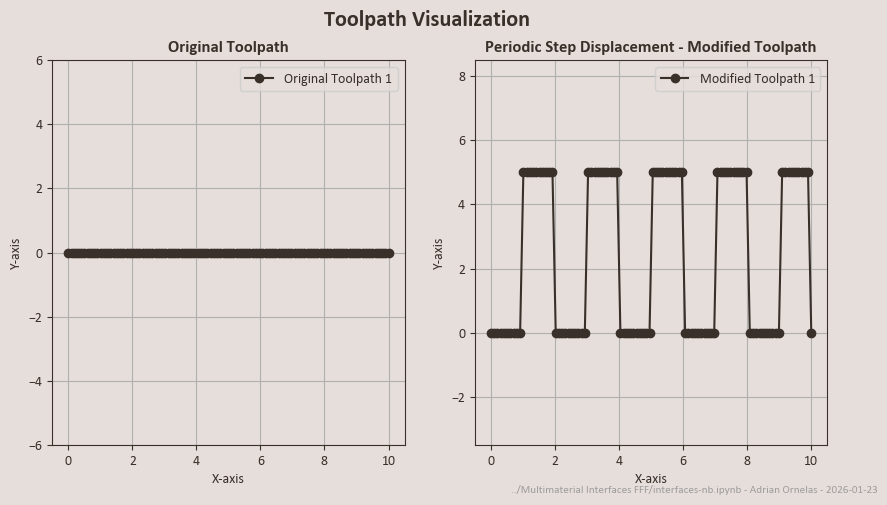

In [3]:
def disp_step(toolpath, step_height, step_interval):
    """
    Apply a periodic step displacement to a given toolpath.
    
    Parameters:
    toolpath (np.ndarray): Original toolpath as a 2D array of shape (N, 2).
    step_height (float): Height of each step.
    step_interval (float): Interval along the X-axis at which steps occur.
    """

    modified_toolpath = np.copy(toolpath)

    for i in range(len(modified_toolpath)):
        x = modified_toolpath[i, 0]
        num_steps = int(x % step_interval)
        displacement = num_steps * step_height
        modified_toolpath[i, 1] += displacement  # Apply displacement to Y coordinate

    return modified_toolpath

original_toolpath = generate_parallel_toolpaths((0, 0), (10, 0), 100, num_paths=1)[0]
modified_toolpath = disp_step(original_toolpath, step_height=5, step_interval=2)

plot_toolpaths(original_toolpath, modified_toolpath, fig_title_1="Original Toolpath", fig_title_2="Periodic Step Displacement - Modified Toolpath")


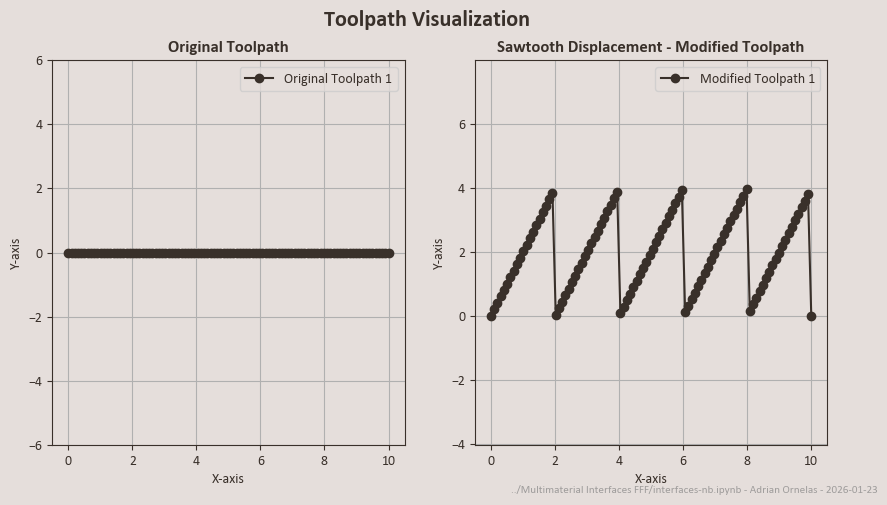

In [10]:
# Sawtooh Periodic Function Displacement map

import numpy as np

def disp_sawtooh(toolpath, period_y, amplitude):
    """
    Apply a sawtooth periodic displacement to a given toolpath.

    Parameters:
    toolpath (np.ndarray): An Nx2 array representing the toolpath coordinates, currently assumed to be along the X-axis.
    period_y (float): The period of the sawtooth wave.
    amplitude (float): The amplitude of the sawtooth wave.

    Returns:
    np.ndarray: The modified toolpath with sawtooth displacement applied.
    """
    modified_toolpath = np.copy(toolpath)
    
    for i in range(len(modified_toolpath)):
        x = modified_toolpath[i, 0]
        displacement = (amplitude / period_y) * (x % period_y)

        # print(displacement)
        modified_toolpath[i, 1] += displacement  # Apply displacement to Y coordinate

    return modified_toolpath

# Example usage

original_toolpath = generate_parallel_toolpaths((0, 0), (10, 0), 100, num_paths=1)[0]
modified_toolpath = disp_sawtooh(original_toolpath, period_y=2, amplitude=4)

plot_toolpaths(original_toolpath, modified_toolpath, fig_title_1="Original Toolpath", fig_title_2="Sawtooth Displacement - Modified Toolpath")

## Working Proof of Concept

First test to see what a basic displacement can look like

Goals here are to apply a periodic displacement to a straight line parametrically.

Future goals will include a reliable and flexible plotting utility, and mulitple different periodic conditions.

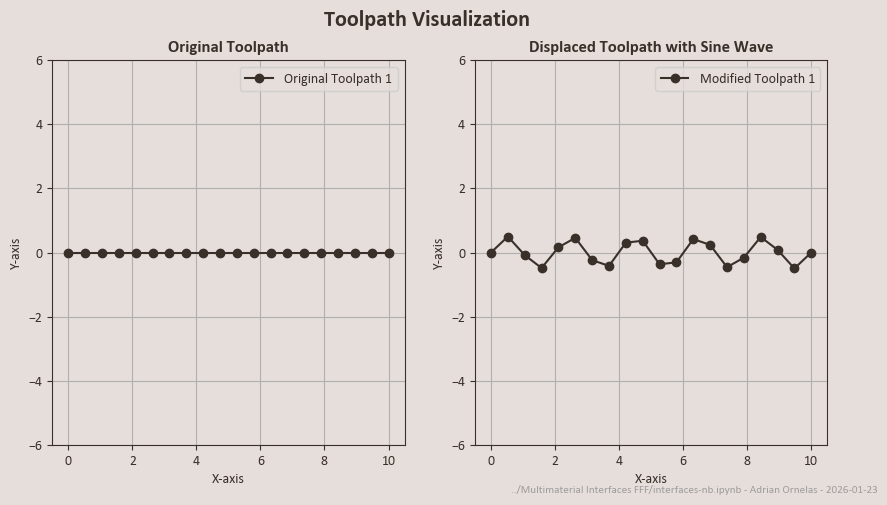

In [12]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

# Project Title: Multimaterial Interfaces for Fused Filament Fabrication Printers

# Project goals: 

# 1. Design and fabricate multimaterial interfaces for FFF printers by modifying existing G-code

# Borrowing from the concept of a Displacement Map in computer graphics, we will apply parametric
# displacement maps to the interfacial walls in along the toolpath to create complex multimaterial interfaces.

# We begin by defining a parametric displacement map function to displace parallel lines, and then abstract the
# displacement map to work along a toolpath defined by a series of points.

# Function to visualize original toolpath and displaced toolpath

# Define toolpath points, in 2D space

toolpath = np.array([[x, 0] for x in np.linspace(0, 10, 20)])

# Define a basic displacement step function

def displacement_map(coords):
    x, y = coords[:, 0], coords[:, 1]
    displacement = 0.5 * np.sin(2 * np.pi * x / 2)  # Sine wave displacement
    displaced_coords = np.column_stack((x, y + displacement))
    return displaced_coords
# Plot original and displaced toolpath

plot_toolpaths(toolpath, displacement_map(toolpath), fig_title_1="Original Toolpath", fig_title_2="Displaced Toolpath with Sine Wave")